# Tutorial: Introducción a Deep Q-Learning (DQN)

Bienvenido a este tutorial sobre **Deep Q-Network (DQN)**. Si eres nuevo en el Aprendizaje por Refuerzo (Reinforcement Learning - RL), ¡estás en el lugar correcto! Vamos a desglosar los conceptos paso a paso, desde lo básico hasta la implementación de un agente capaz de aprender a jugar un videojuego simple.

## 1. ¿Qué es el Aprendizaje por Refuerzo (RL)?

Imagina que estás enseñando a un perro a sentarse. 
- Si se sienta cuando se lo ordenas, le das una galleta (recompensa positiva).
- Si no lo hace, no recibe nada (o quizás un leve regaño, recompensa negativa).
Con el tiempo, el perro aprende que la acción "sentarse" ante la orden conduce a una recompensa.

En RL, tenemos:
- **Agente**: El que aprende (el perro, o nuestro algoritmo).
- **Entorno (Environment)**: El mundo con el que interactúa (la habitación, nosotros).
- **Estado (State, $s$)**: La situación actual (el perro está de pie, nosotros decimos "sit").
- **Acción (Action, $a$)**: Lo que hace el agente (sentarse, ladrar, correr).
- **Recompensa (Reward, $r$)**: La retroalimentación (la galleta).

El objetivo del agente es maximizar la suma total de recompensas a lo largo del tiempo. Esto se llama el **recompensa acumulada** o **retorno** ($G_t$).

---

## 2. De Q-Learning a Deep Q-Learning

### Q-Learning (El enfoque clásico)
Antes de "Deep" RL, existía **Q-Learning**. La idea central es aprender una función $Q(s, a)$ que nos diga: 
*"Si estoy en el estado $s$ y tomo la acción $a$, ¿cuánta recompensa total espero obtener al final?"*

Imagina una tabla (tabla Q) donde las filas son estados y las columnas son acciones. Llenamos esta tabla con valores estimados. Cuando el agente tiene que actuar, simplemente mira la fila de su estado actual y elige la acción con el valor más alto.

**La Ecuación de Bellman** para actualizar esta tabla es:
$$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$

Donde:
- $\alpha$: Tasa de aprendizaje (cuánto "confiamos" en la nueva información).
- $\gamma$: Factor de descuento (cuánto nos importa el futuro vs. el presente).
- $s'$: El siguiente estado al que llegamos.
- $\max_{a'} Q(s', a')$: La mejor estimación de futuro desde el nuevo estado.

### El Problema
Si el entorno es simple (como un laberinto pequeño), una tabla funciona. Pero, env videojuego como Atari (donde el estado son los pixeles de la pantalla), hay infinitos estados posibles. ¡No podemos tener una tabla con trillones de filas!

### La Solución: Deep Q-Network (DQN)
En lugar de una tabla, usamos una **Red Neuronal** para aproximar la función Q.
$$Q(s, a; \theta) \approx Q^*(s, a)$$
La red toma el estado $s$ como entrada y devuelve los valores Q para todas las acciones posibles.

---

## 3. Los Trucos de DQN

Entrenar una red neuronal para RL es inestable. DQN introdujo dos trucos clave para hacerlo funcionar:

### 1. Experience Replay (Repetición de Experiencia)
En lugar de aprender de la experiencia inmediatamente y descartarla (como en Q-Learning estándar), guardamos las transiciones $(s, a, r, s', done)$ en una memoria (buffer). Durante el entrenamiento, tomamos un **lote aleatorio** de experiencias pasadas para entrenar la red.
- **Por qué ayuda:** Rompe la correlación entre muestras consecutivas (los datos consecutivos son muy similares, lo que confunde a la red).

### 2. Target Network (Red Objetivo)
En la ecuación de Bellman, el objetivo ($r + \gamma \max Q(s', a')$) cambia constantemente porque usamos la misma red para calcular el valor objetivo y el valor predicho. Es como tratar de golpear un blanco en movimiento.
- **Solución:** Creamos una copia de la red llamada **Target Network**. Usamos esta red copia para calcular el objetivo y la mantenemos congelada por varios pasos, actualizándola solo ocasionalmente con los pesos de la red principal.

---

## 4. Implementación Práctica

Vamos a implementar DQN para resolver el entorno **CartPole-v1** de Gymnasium. El objetivo es equilibrar un palo sobre un carro moviéndolo de izquierda a derecha.

In [1]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Configuración para usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


### La Red Neuronal (Q-Network)
Una red simple que toma el estado (4 valores en CartPole: posición, velocidad, ángulo, velocidad angular) y devuelve un valor para cada acción (2 acciones: izquierda, derecha).

In [2]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # Red simple: Entrada -> 128 neuronas -> 128 neuronas -> Salida
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Experience Replay Buffer
Una estructura para guardar y muestrear experiencias.

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Guardar una transición"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Obtener un lote aleatorio"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Hiperparámetros y Configuración
Definimos los parámetros clave del entrenamiento.

In [4]:
# Hiperparámetros
BATCH_SIZE = 128        # Tamaño del lote para entrenar
GAMMA = 0.99            # Factor de descuento (valoramos el futuro)
EPS_START = 0.9         # Epsilon inicial (probabilidad de explorar)
EPS_END = 0.05          # Epsilon final
EPS_DECAY = 1000        # Qué tan rápido decae Epsilon
TAU = 0.005             # Tasa de actualización suave de la red objetivo
LR = 1e-4               # Tasa de aprendizaje (Learning Rate)

# Inicializar entorno
env = gym.make("CartPole-v1")
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

# Redes (Policy y Target)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # Copiamos pesos iniciales

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

### Función para elegir acción (Epsilon-Greedy)
Con probabilidad $\epsilon$ elegimos una acción aleatoria (exploración), de lo contrario elegimos la mejor acción según nuestra red (explotación).

In [5]:
def select_action(state):
    global steps_done
    sample = random.random()
    # Decaimiento de epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) devolverá el valor más grande. La segunda columna del resultado es el índice
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

### Función de Entrenamiento (Un paso de optimización)
Aquí ocurre la magia matemática:
1. Muestreamos un lote de experiencias.
2. Calculamos $Q(s, a)$ actual.
3. Calculamos $V_{target} = r + \gamma \max Q(s', a')$ usando la red objetivo.
4. Calculamos la pérdida (Loss) entre ambos.
5. Retropropagación (Backpropagation) para actualizar la red.

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
        
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Máscara de estados no finales (donde el episodio no terminó)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Calcular Q(s, a) - La red nos da Q para todas las acciones, seleccionamos las que tomamos
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Calcular V(s') para los siguientes estados usando la red objetivo
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    
    # Calcular el valor Q esperado (Target)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Calcular pérdida (Huber loss es robusta a outliers)
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimizar el modelo
    optimizer.zero_grad()
    loss.backward()
    # Clip gradients para estabilidad
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Bucle de Entrenamiento
Entrenamos durante un número de episodios. Observa cómo la duración de los episodios (cuánto tiempo aguanta el palo sin caerse) debería aumentar.

In [7]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50   # Menos episodios si estamos en CPU para que el tutorial sea rápido

episode_durations = []

print("Iniciando entrenamiento...")

for i_episode in range(num_episodes):
    # Inicializar entorno y estado
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    for t in range(1000): # Máximo 1000 pasos por episodio
        # Seleccionar y ejecutar acción
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Guardar transición en memoria
        memory.push(state, action, next_state, reward, done)

        # Mover al siguiente estado
        state = next_state

        # Optimizar (entrenar) la red
        optimize_model()

        # Actualización suave de la red objetivo
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            break

    if i_episode % 10 == 0:
        print(f"Episodio {i_episode}, Duración: {episode_durations[-1]}")

print("¡Entrenamiento completado!")

Iniciando entrenamiento...
Episodio 0, Duración: 29
Episodio 10, Duración: 11
Episodio 20, Duración: 13
Episodio 30, Duración: 13
Episodio 40, Duración: 11
¡Entrenamiento completado!


### Visualización de Resultados

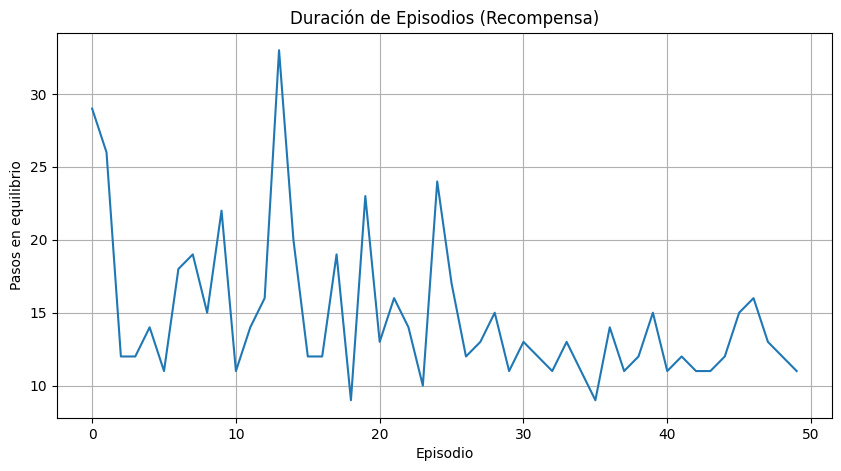

In [8]:
plt.figure(figsize=(10,5))
plt.title("Duración de Episodios (Recompensa)")
plt.plot(episode_durations)
plt.xlabel("Episodio")
plt.ylabel("Pasos en equilibrio")
plt.grid()
plt.show()

## 6. Visualización del Agente

Vamos a ver cómo se comporta nuestro agente entrenado. Generaremos una animación de un episodio.
Nota: Esto requiere `matplotlib` para la animación y `ipython` para mostrarla en el notebook.

In [9]:
from matplotlib import animation
from IPython.display import HTML

def display_video(frames):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    plt.close()
    return HTML(anim.to_jshtml())

# Correr un episodio y guardar frames
env_viz = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env_viz.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

frames = []
for t in range(500):
    frames.append(env_viz.render())
    
    # Usar la red para elegir la mejor acción (sin exploración aleatoria)
    with torch.no_grad():
        action = policy_net(state).max(1)[1].view(1, 1)
        
    observation, reward, terminated, truncated, _ = env_viz.step(action.item())
    done = terminated or truncated
    
    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    state = next_state
    if done:
        break

env_viz.close()
print(f"Visualizando episodio de {len(frames)} pasos...")
display_video(frames)

Visualizando episodio de 9 pasos...


## 7. Conclusión

Has implementado un agente DQN desde cero. 
- La **Red Neuronal** aproxima los valores Q.
- El **Replay Buffer** nos permite reutilizar experiencias pasadas y estabilizar el entrenamiento.
- La **Target Network** nos da un objetivo estable para aprender.

¡Felicidades! Ahora entiendes los bloques fundamentales del Deep Reinforcement Learning.